# Compare Temperature Across Locations
* TMAX: The maximum temperature on a day
* TMIN: The minimum temperature on a day
* TAVG: (If available) The average temperature on a day

In [1]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import sys
sys.path.append(os.path.dirname(os.getcwd()))

import functions
# from functions import map_stations

In [2]:
# Station 1 - Clatskanie
df = pd.read_csv('../data/temperature_97016.csv')
df = df.assign(year = pd.to_datetime(df['DATE']).dt.year)
df = df[df['year']<2025]

# Verify station 
# functions.view_station_date_ranges(df)
# geo_data = pd.read_csv('../data/geo_data.csv')
# functions.map_stations(geo_data)

df1 = df[df['STATION']=='USC00351643']
# df[df['TAVG'].notnull()]['STATION'].unique()

In [3]:
# Station 2 - Portland
df = pd.read_csv('../data/temperature_97218.csv')
df = df.assign(year = pd.to_datetime(df['DATE']).dt.year)
df = df[df['year']<2025]
df.STATION.unique()

df2 = df.copy()

In [4]:
df1_suffix = '_CLATSKANIE'
df2_suffix = '_PDX'
df = df1.merge(df2,
          on=['DATE', 'year'],
          how='inner',
          suffixes=(df1_suffix, df2_suffix)
          ).drop(['STATION_PDX', 'STATION_CLATSKANIE'], axis=1)

Maximum Temperature

In [5]:
df[['TMAX_CLATSKANIE', 'TMAX_PDX']].describe()

,TMAX_CLATSKANIE,TMAX_PDX
count,30638.000000,30728.000000
mean,59.716888,62.787002
std,12.642279,14.488503
min,17.000000,14.000000
25%,50.000000,52.000000
50%,59.000000,61.000000
75%,69.000000,73.000000
max,103.000000,116.000000


In [6]:
df

,NAME_CLATSKANIE,DATE,TAVG_CLATSKANIE,TMAX_CLATSKANIE,TMIN_CLATSKANIE,year,NAME_PDX,TAVG_PDX,TMAX_PDX,TMIN_PDX
0,"CLATSKANIE, OR US",1940-10-14,NaN,67.0,48.0,1940,"PORTLAND INTERNATIONAL AIRPORT, OR US",NaN,70,53
1,"CLATSKANIE, OR US",1940-10-15,NaN,63.0,51.0,1940,"PORTLAND INTERNATIONAL AIRPORT, OR US",NaN,64,52
2,"CLATSKANIE, OR US",1940-10-16,NaN,65.0,50.0,1940,"PORTLAND INTERNATIONAL AIRPORT, OR US",NaN,72,50
3,"CLATSKANIE, OR US",1940-10-17,NaN,68.0,56.0,1940,"PORTLAND INTERNATIONAL AIRPORT, OR US",NaN,72,58
4,"CLATSKANIE, OR US",1940-10-18,NaN,71.0,60.0,1940,"PORTLAND INTERNATIONAL AIRPORT, OR US",NaN,78,58
...,...,...,...,...,...,...,...,...,...,...
30723,"CLATSKANIE, OR US",2024-12-27,NaN,54.0,42.0,2024,"PORTLAND INTERNATIONAL AIRPORT, OR US",49.0,53,45
30724,"CLATSKANIE, OR US",2024-12-28,NaN,50.0,43.0,2024,"PORTLAND INTERNATIONAL AIRPORT, OR US",51.0,55,48
30725,"CLATSKANIE, OR US",2024-12-29,NaN,51.0,43.0,2024,"PORTLAND INTERNATIONAL AIRPORT, OR US",49.0,52,43
30726,"CLATSKANIE, OR US",2024-12-30,NaN,49.0,36.0,2024,"PORTLAND INTERNATIONAL AIRPORT, OR US",45.0,50,41


In [7]:
# Stack the TMAX of the locations; make the wide data long
x = pd.melt(df[df['year']==2024],
            id_vars='DATE',
            value_vars=['TMAX_CLATSKANIE', 'TMAX_PDX'])
x['DATE'] = pd.to_datetime(x['DATE'])
x

,DATE,variable,value
0,2024-01-01,TMAX_CLATSKANIE,47.0
1,2024-01-02,TMAX_CLATSKANIE,48.0
2,2024-01-03,TMAX_CLATSKANIE,44.0
3,2024-01-04,TMAX_CLATSKANIE,48.0
4,2024-01-05,TMAX_CLATSKANIE,48.0
...,...,...,...
727,2024-12-27,TMAX_PDX,53.0
728,2024-12-28,TMAX_PDX,55.0
729,2024-12-29,TMAX_PDX,52.0
730,2024-12-30,TMAX_PDX,50.0


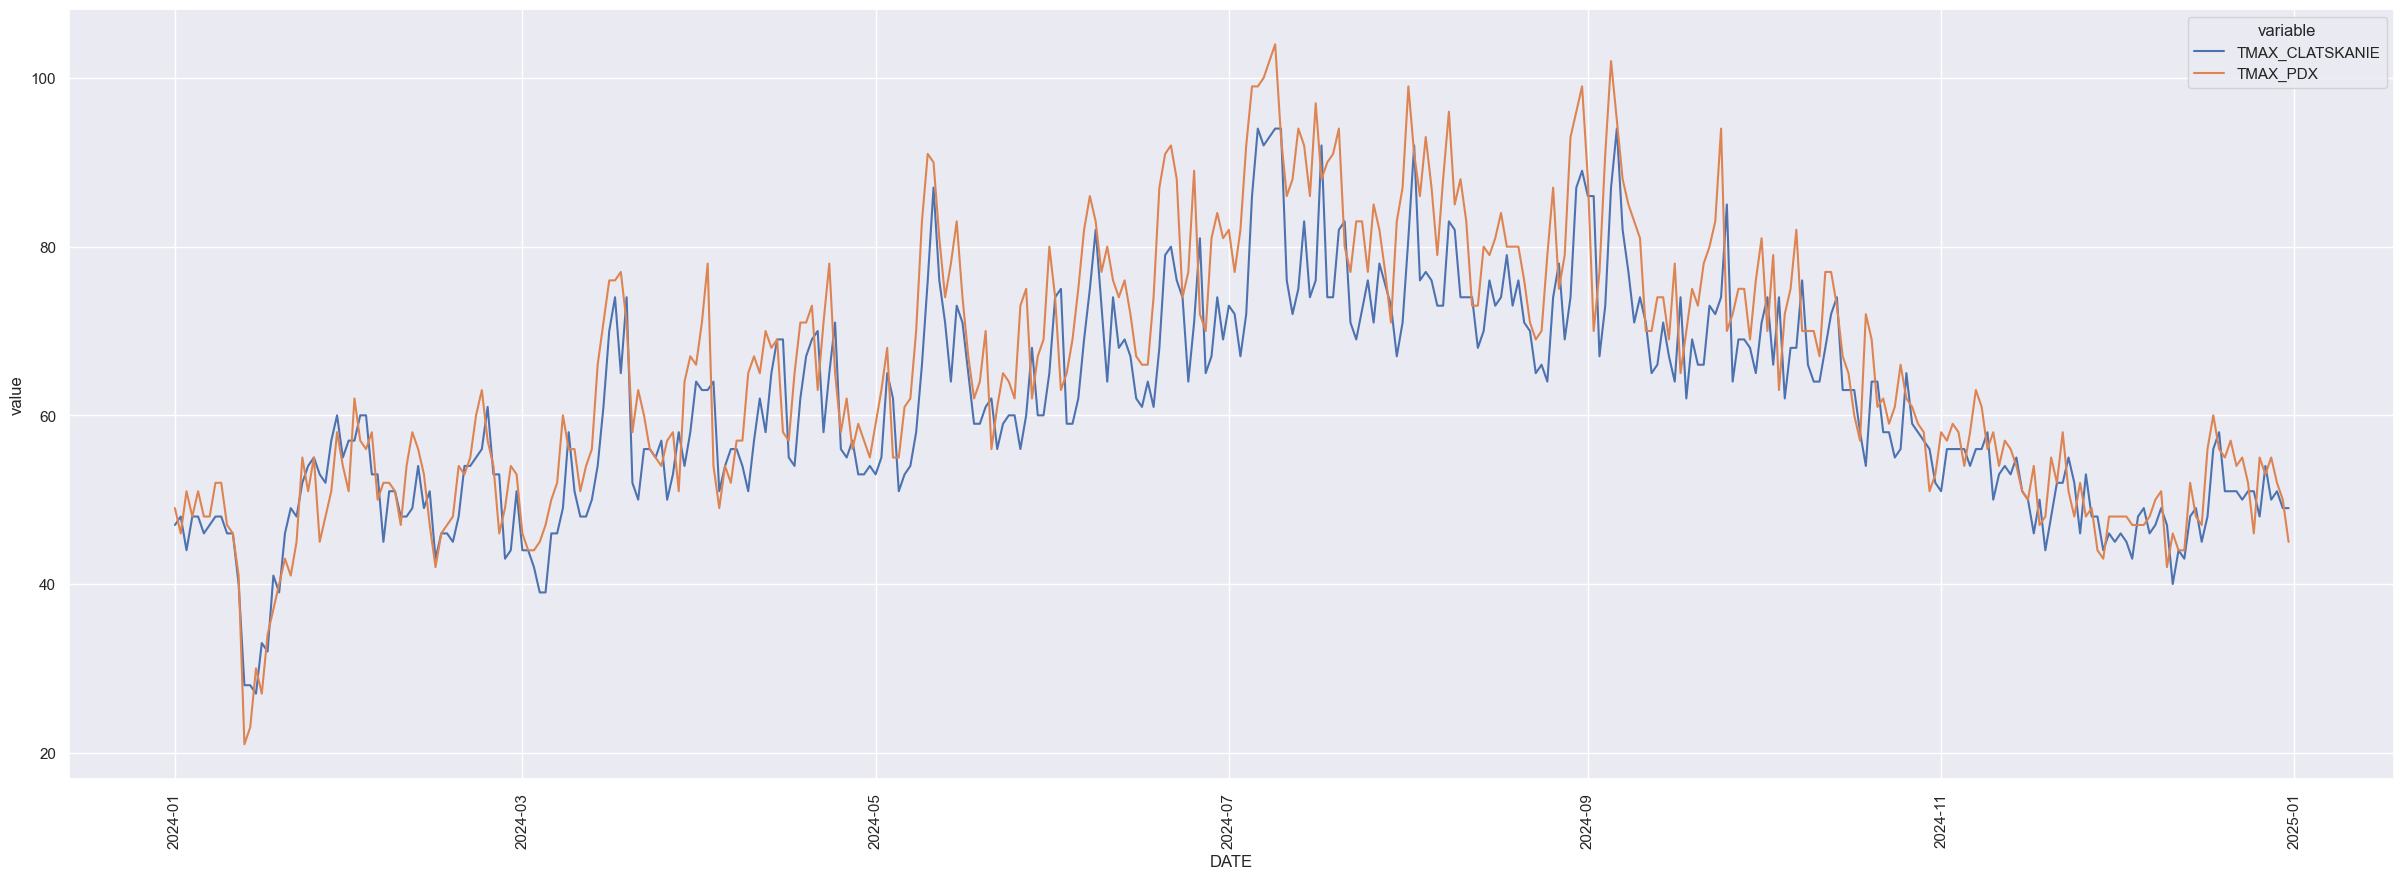

In [10]:
p = sns.set(rc = {'figure.figsize':(30, 10)}) # longer but not taller (x, y)
p = sns.lineplot(x,
             x='DATE',
             y='value',
             hue='variable')

ticks = plt.xticks(rotation=90)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

Minimum Temperature

In [9]:
df[['TMIN_CLATSKANIE', 'TMIN_PDX']].describe()

,TMIN_CLATSKANIE,TMIN_PDX
count,30636.000000,30728.000000
mean,42.249478,45.150807
std,9.147526,9.873956
min,1.000000,-3.000000
25%,35.000000,38.000000
50%,42.000000,45.000000
75%,50.000000,53.000000
max,66.000000,75.000000
